In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas_profiling as pdp
import lightgbm as lgb
import featuretools as ft

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
path = os.getcwd()
print(path)

/workspace/code


In [4]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [5]:
df_train = pd.read_csv('/workspace/data/train.csv')
df_test =pd.read_csv('/workspace/data/test.csv')

In [6]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [8]:
df_train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

In [10]:
df_train_1_corr = df_train.iloc[:,-12:-1].corr()

In [11]:
mask = np.triu(np.ones_like(df_train_1_corr, dtype=bool))

<AxesSubplot:>

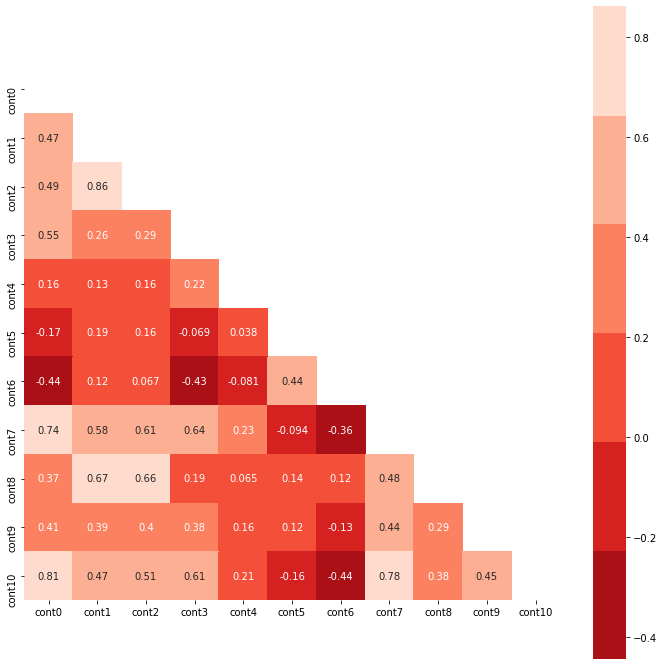

In [12]:
plt.figure(figsize=(12,12))
cmap = sns.color_palette("Reds_r")
sns.heatmap(df_train_1_corr, square=True, annot=True, mask=mask, cmap=cmap)

## LightGBMでとりあえず学習

## ラベルエンコーディング＆外れ値除去＆特徴量生成

In [10]:
# columnsの列名を確認
df_train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

### ラベルエンコーディング(カテゴリ変数)

In [9]:
cat_list = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18']

In [10]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [11]:
df_train[cat_list] =oe.fit_transform(df_train[cat_list])

In [13]:
df_test[cat_list] =oe.fit_transform(df_test[cat_list])

### 外れ値除去

#### IQR(四分位範囲)外のデータを除外  
外れ値の影響を少なくするためIQRスコアを算出する  
ラベルエンコーディングしたカテゴリ変数の箱ひげ図を表示  
ラベルエンコーディング→外れ値除去→欠損値補完の順番  
※今回のデータは欠損値がないが、欠損値があるデータで外れ値除去前に欠損値を補完すると外れ値が考慮された補完となるため

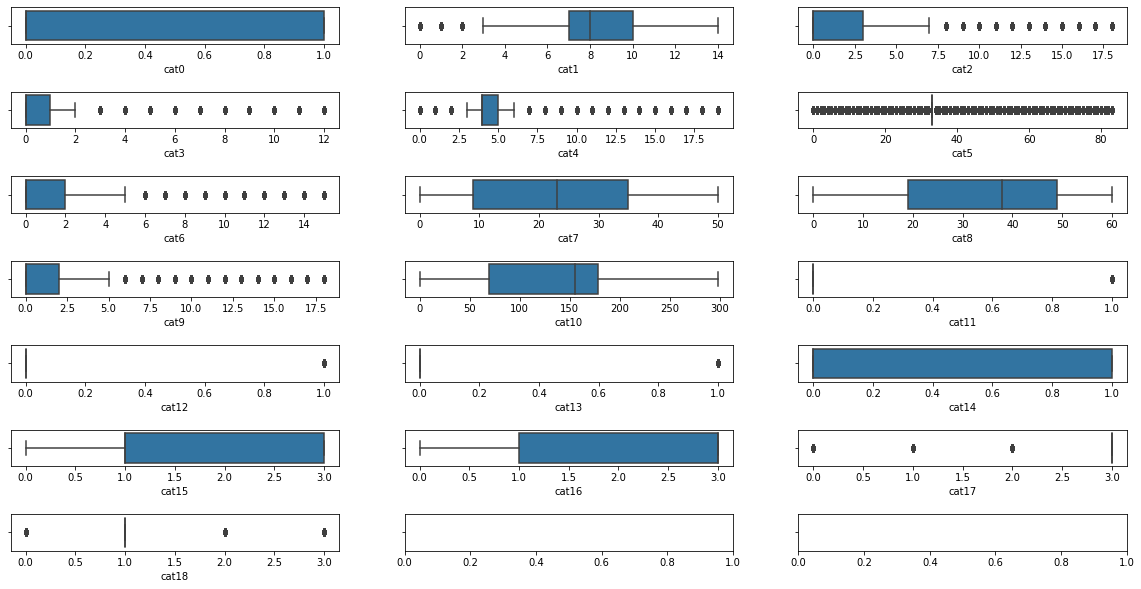

In [15]:
fig, (
      (ax0, ax1, ax2),
      (ax3, ax4, ax5),
      (ax6, ax7, ax8),
      (ax9, ax10, ax11),
      (ax12, ax13, ax14),
      (ax15, ax16, ax17),
      (ax18, ax19, ax20)
    ) = plt.subplots(nrows=7, ncols=3, sharey=True, figsize=(20, 10))

plt.subplots_adjust(hspace=1.3) 

sns.boxplot(x=df_train.cat0, ax=ax0)
sns.boxplot(x=df_train.cat1, ax=ax1)
sns.boxplot(x=df_train.cat2, ax=ax2)
sns.boxplot(x=df_train.cat3, ax=ax3)
sns.boxplot(x=df_train.cat4, ax=ax4)
sns.boxplot(x=df_train.cat5, ax=ax5)
sns.boxplot(x=df_train.cat6, ax=ax6)
sns.boxplot(x=df_train.cat7, ax=ax7)
sns.boxplot(x=df_train.cat8, ax=ax8)
sns.boxplot(x=df_train.cat9, ax=ax9)
sns.boxplot(x=df_train.cat10, ax=ax10)
sns.boxplot(x=df_train.cat11, ax=ax11)
sns.boxplot(x=df_train.cat12, ax=ax12)
sns.boxplot(x=df_train.cat13, ax=ax13)
sns.boxplot(x=df_train.cat14, ax=ax14)
sns.boxplot(x=df_train.cat15, ax=ax15)
sns.boxplot(x=df_train.cat16, ax=ax16)
sns.boxplot(x=df_train.cat17, ax=ax17)
sns.boxplot(x=df_train.cat18,ax=ax18)

plt.show()

閉区間から外れている値を除外する  
Q<sub>1/4</sub> = df_train.quantile(0.25) 第一四分位点  
Q<sub>3/4</sub> = df_train.quantile(0.75) 第三四分位点    
閉区間(Q<sub>1/4</sub>- 1.5\*IQR,Q<sub>3/4</sub>- 1.5\*IQR  IQR=Q<sub>3/4</sub>-Q<sub>1/4</sub>)

In [32]:
# IQRスコア外のデータを削除(列毎処理)
# id列からcont10までの外れ値をNaNに変換
for i in df_train.columns:
    if i != 'target':
        q1 = df_train[i].quantile(0.25)
        q3 = df_train[i].quantile(0.75)
        iqr = q3 - q1
        df_train[i] = df_train[i][~((df_train[i]<(q1-1.5*iqr)) | (df_train[i]>(q3+1.5*iqr)))]

In [33]:
for i in df_test.columns:
    if i != 'target':
        q1 = df_test[i].quantile(0.25)
        q3 = df_test[i].quantile(0.75)
        iqr = q3 - q1
        df_test[i] = df_test[i][~((df_test[i]<(q1-1.5*iqr)) | (df_test[i]>(q3+1.5*iqr)))]

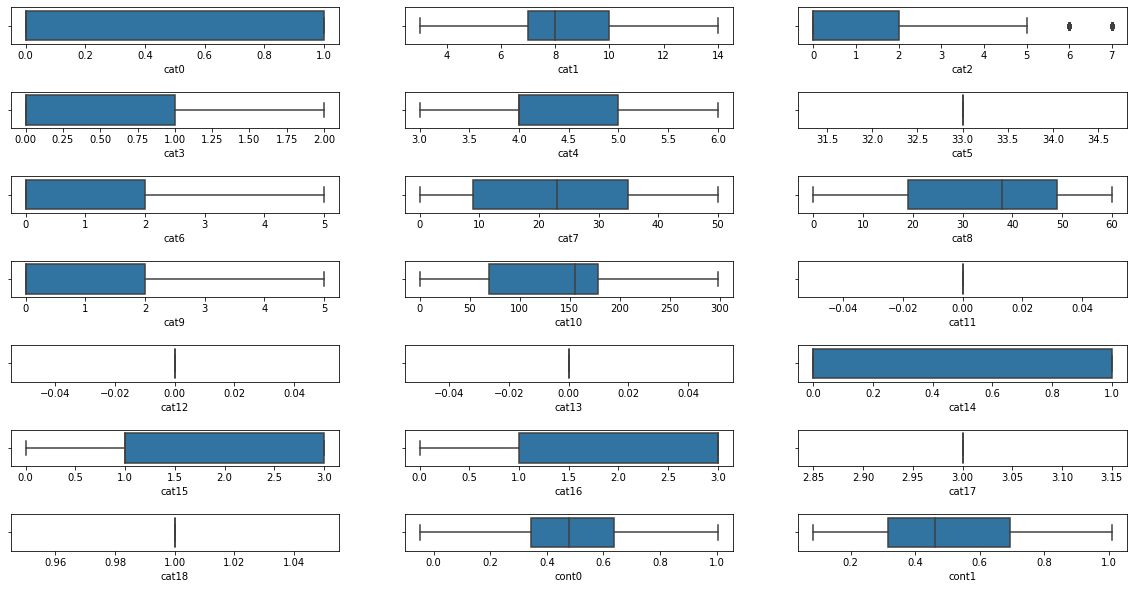

In [36]:
# 外れ値除去できたか箱ひげ図で確認
fig, (
      (ax0, ax1, ax2),
      (ax3, ax4, ax5),
      (ax6, ax7, ax8),
      (ax9, ax10, ax11),
      (ax12, ax13, ax14),
      (ax15, ax16, ax17),
      (ax18, ax19, ax20)
    ) = plt.subplots(nrows=7, ncols=3, sharey=True, figsize=(20, 10))

plt.subplots_adjust(hspace=1.3) 

sns.boxplot(x=df_train.cat0, ax=ax0)
sns.boxplot(x=df_train.cat1, ax=ax1)
sns.boxplot(x=df_train.cat2, ax=ax2)
sns.boxplot(x=df_train.cat3, ax=ax3)
sns.boxplot(x=df_train.cat4, ax=ax4)
sns.boxplot(x=df_train.cat5, ax=ax5)
sns.boxplot(x=df_train.cat6, ax=ax6)
sns.boxplot(x=df_train.cat7, ax=ax7)
sns.boxplot(x=df_train.cat8, ax=ax8)
sns.boxplot(x=df_train.cat9, ax=ax9)
sns.boxplot(x=df_train.cat10, ax=ax10)
sns.boxplot(x=df_train.cat11, ax=ax11)
sns.boxplot(x=df_train.cat12, ax=ax12)
sns.boxplot(x=df_train.cat13, ax=ax13)
sns.boxplot(x=df_train.cat14, ax=ax14)
sns.boxplot(x=df_train.cat15, ax=ax15)
sns.boxplot(x=df_train.cat16, ax=ax16)
sns.boxplot(x=df_train.cat17, ax=ax17)
sns.boxplot(x=df_train.cat18,ax=ax18)
sns.boxplot(x=df_train.cont0,ax=ax19)
sns.boxplot(x=df_train.cont1,ax=ax20)

plt.show()

In [48]:
# NaNに置換されたデータ数の確認
df_train.isnull().sum()

id            0
cat0          0
cat1      19097
cat2      41062
cat3      16841
cat4      35264
cat5      61437
cat6      23398
cat7          0
cat8          0
cat9      26809
cat10         0
cat11     41068
cat12     42861
cat13      7288
cat14         0
cat15         0
cat16         0
cat17     52875
cat18     44518
cont0         0
cont1         0
cont2         0
cont3         0
cont4         0
cont5         0
cont6         0
cont7         0
cont8      1915
cont9         9
cont10    35952
target        0
dtype: int64

In [51]:
df_test.isnull().sum()

id            0
cat0          0
cat1          0
cat2      27540
cat3      11418
cat4      23533
cat5      41084
cat6      15622
cat7          0
cat8          0
cat9      12596
cat10         0
cat11     27414
cat12     28902
cat13      4984
cat14         0
cat15         0
cat16         0
cat17     34934
cat18     29932
cont0         0
cont1         0
cont2         0
cont3         0
cont4         0
cont5         0
cont6         0
cont7         0
cont8      1292
cont9         2
cont10    24108
dtype: int64

In [53]:
# NaNを平均値で補完
for i in df_train.columns:
    if df_train[i].isnull().sum() > 0:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [54]:
# NaNを平均値で補完
for i in df_test.columns:
    if df_test[i].isnull().sum() > 0:
        df_test[i].fillna(df_test[i].mean(), inplace=True)

In [57]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0.0,8.0,0.0,1.0,4.416517,33.0,0.000000,44.0,54.0,0.000000,258.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0.0,8.0,0.0,0.0,4.000000,33.0,0.764825,48.0,3.0,5.000000,162.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0.0,10.0,0.0,0.0,4.000000,33.0,0.000000,30.0,38.0,0.920989,69.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0.0,10.0,0.0,2.0,4.000000,33.0,0.000000,50.0,3.0,5.000000,241.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.448646,0
4,4,0.0,8.0,6.0,1.0,4.000000,33.0,2.000000,32.0,54.0,0.000000,75.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [61]:
df_test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,0.0,5.0,0.0,0.0,5.0,33.0,0.000000,8.0,23.0,0.0,249.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084
1,6,0.0,7.0,2.0,0.0,4.0,33.0,0.765786,31.0,51.0,0.0,269.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,0.0,13.0,2.0,0.0,5.0,33.0,0.000000,8.0,28.0,0.0,121.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,1.0,11.0,2.0,0.0,5.0,33.0,0.000000,30.0,23.0,0.0,162.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,0.0,5.0,0.0,1.0,5.0,33.0,0.000000,8.0,46.0,0.0,173.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


#### 特徴量生成

In [62]:
def wrangle(X):
    """
    simple difference
    ratio a
    power
    square root
    polynomial a
    polynomial b
    polynomial c
    """
    
    X['diff_1'] = abs(X['cat0'] - X['cat1'])
    X['diff_2'] = abs(X['cat2'] - X['cat3'])
    X['diff_3'] = abs(X['cat4'] - X['cat5'])
    X['diff_4'] = abs(X['cat6'] - X['cat7'])
    X['diff_5'] = abs(X['cat8'] - X['cat9'])
    X['diff_6'] = abs(X['cat10'] - X['cat11'])
    X['diff_7'] = abs(X['cat12'] - X['cat13'])
    X['diff_8'] = abs(X['cat14'] - X['cat15'])
    X['diff_8'] = abs(X['cat16'] - X['cat17'])
    X['diff_8'] = abs(X['cat18'] - X['cat0']) 
    X['diff_9'] = abs(X['cont0'] - X['cont1'])
    X['diff_10'] = abs(X['cont2'] - X['cont3'])
    X['diff_11'] = abs(X['cont4'] - X['cont5'])
    X['diff_12'] = abs(X['cont6'] -X['cont7'])
    X['diff_13'] = abs(X['cont8'] -X['cont9'])
    X['diff_14'] = abs(X['cont10'] -X['cont0'])
    
    
    X['rat_1'] = 1 / (X['cont0'] + X['cont1']**2)
    X['rat_2'] = 1 / (X['cont2'] + X['cont3']**2)
    X['rat_3'] = 1 / (X['cont4'] + X['cont5']**2)
    X['rat_4'] = 1 / (X['cont6'] + X['cont7']**2)
    X['rat_5'] = 1 / (X['cont8'] + X['cont9']**2)
    X['rat_6'] = 1 / (X['cont10'] + X['cont7']**2)
    
    X['pow_0'] = X['cont0']**2
    X['pow_1'] = X['cont1']**2
    X['pow_2'] = X['cont2']**2
    X['pow_3'] = X['cont3']**2
    X['pow_4'] = X['cont4']**2
    X['pow_5'] = X['cont5']**2
    X['pow_6'] = X['cont6']**2
    X['pow_7'] = X['cont7']**2
    X['pow_8'] = X['cont8']**2
    X['pow_9'] = X['cont9']**2
    X['pow_10'] = X['cont10']**2
    
    X['sqrt_0'] = np.sqrt(X['cont0'])
    X['sqrt_1'] = np.sqrt(X['cont1'])
    X['sqrt_2'] = np.sqrt(X['cont2'])
    X['sqrt_3'] = np.sqrt(X['cont3'])
    X['sqrt_4'] = np.sqrt(X['cont4'])
    X['sqrt_5'] = np.sqrt(X['cont5'])
    X['sqrt_6'] = np.sqrt(X['cont6'])
    X['sqrt_7'] = np.sqrt(X['cont7'])
    X['sqrt_8'] = np.sqrt(X['cont8'])
    X['sqrt_9'] = np.sqrt(X['cont9'])
    X['sqrt_10'] = np.sqrt(X['cont10'])

    X['poly_0'] = 1 + 5*X['cont0'] + 8*X['cont0']**2
    X['poly_1'] = 1 + 5*X['cont1'] + 8*X['cont1']**2
    X['poly_2'] = 1 + 5*X['cont2'] + 8*X['cont2']**2
    X['poly_3'] = 1 + 5*X['cont3'] + 8*X['cont3']**2
    X['poly_4'] = 1 + 5*X['cont4'] + 8*X['cont4']**2
    X['poly_5'] = 1 + 5*X['cont5'] + 8*X['cont5']**2
    X['poly_6'] = 1 + 5*X['cont6'] + 8*X['cont6']**2
    X['poly_7'] = 1 + 5*X['cont7'] + 8*X['cont7']**2
    X['poly_8'] = 1 + 5*X['cont8'] + 8*X['cont8']**2
    X['poly_9'] = 1 + 5*X['cont9'] + 8*X['cont9']**2
    X['poly_10'] =1 + 5*X['cont10'] + 8*X['cont10']**2
    

    X['poly_b_0'] = X['cont0'] / X['cont0']**2
    X['poly_b_1'] = X['cont1'] / X['cont1']**2
    X['poly_b_2'] = X['cont2'] / X['cont2']**2
    X['poly_b_3'] = X['cont3'] / X['cont3']**2
    X['poly_b_4'] = X['cont4'] / X['cont4']**2
    X['poly_b_5'] = X['cont5'] / X['cont5']**2
    X['poly_b_6'] = X['cont6'] / X['cont6']**2
    X['poly_b_7'] = X['cont7'] / X['cont7']**2
    X['poly_b_8'] = X['cont8'] / X['cont8']**2
    X['poly_b_9'] = X['cont9'] / X['cont9']**2
    X['poly_b_10'] = X['cont10'] / X['cont10']**2
    

    X['drat_1'] = 1 / (5*X['cont0'] + 8*X['cont1']**2)
    X['drat_2'] = 1 / (5*X['cont2'] + 8*X['cont3']**2)
    X['drat_3'] = 1 / (5*X['cont4'] + 8*X['cont5']**2)
    X['drat_4'] = 1 / (5*X['cont6'] + 8*X['cont7']**2)
    X['drat_5'] = 1 / (5*X['cont8'] + 8*X['cont9']**2)
    X['drat_6'] = 1 / (5*X['cont10'] + 8*X['cont7']**2)
    
    return X

In [63]:
# 特徴量生成の関数を実行
df_train = wrangle(df_train)
df_test = wrangle(df_test)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [65]:
df_test

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9,diff_10,diff_11,diff_12,diff_13,diff_14,rat_1,rat_2,rat_3,rat_4,rat_5,rat_6,pow_0,pow_1,pow_2,pow_3,pow_4,pow_5,pow_6,pow_7,pow_8,pow_9,pow_10,sqrt_0,sqrt_1,sqrt_2,sqrt_3,sqrt_4,sqrt_5,sqrt_6,sqrt_7,sqrt_8,sqrt_9,sqrt_10,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9,poly_10,poly_b_0,poly_b_1,poly_b_2,poly_b_3,poly_b_4,poly_b_5,poly_b_6,poly_b_7,poly_b_8,poly_b_9,poly_b_10,drat_1,drat_2,drat_3,drat_4,drat_5,drat_6
0,5,0.0,5.0,0.0,0.000000,5.000000,33.0,0.000000,8.0,23.0,0.0,249.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084,5.0,0.000000,28.000000,8.000000,23.0,249.0,0.0,1.0,0.027570,0.144788,0.128190,0.104444,0.238343,0.259035,0.800410,0.908003,2.817419,1.019178,1.373774,1.137633,0.501434,0.541240,0.334508,0.522952,0.052001,0.126898,0.303876,0.429933,0.357999,0.129591,0.201677,0.841498,0.857724,0.760504,0.850385,0.477532,0.596848,0.742462,0.809749,0.773518,0.599990,0.670138,8.552067,9.008370,6.567891,8.799384,2.556192,3.796318,6.187251,7.717933,6.855648,3.836665,4.858836,1.412191,1.359268,1.729008,1.382831,4.385253,2.807197,1.814062,1.525104,1.671317,2.777874,2.226753,0.127056,0.141334,0.463958,0.161402,0.248239,0.175905
1,6,0.0,7.0,2.0,0.000000,4.000000,33.0,0.765786,31.0,51.0,0.0,269.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580,7.0,2.000000,29.000000,30.234214,51.0,269.0,0.0,1.0,0.297934,0.412283,0.195054,0.405627,0.217576,0.223057,1.408358,0.836286,0.811326,1.475999,1.497552,1.223841,0.374100,0.098410,0.862828,0.266878,0.360203,0.632380,0.061995,0.428520,0.121065,0.319813,0.150994,0.782072,0.560092,0.963787,0.718751,0.774706,0.891753,0.498986,0.809082,0.589867,0.752011,0.623362,7.050983,3.355795,12.547046,5.718035,6.882475,10.035161,2.740895,7.701230,3.708236,6.386103,4.150856,1.634957,3.187725,1.076559,1.935725,1.666196,1.257508,4.016268,1.527617,2.874029,1.768284,2.573472,0.260047,0.147505,0.124071,0.213991,0.232654,0.186183
2,8,0.0,13.0,2.0,0.000000,5.000000,33.0,0.000000,8.0,28.0,0.0,121.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592,13.0,2.000000,28.000000,8.000000,28.0,121.0,0.0,1.0,0.008088,0.080148,0.028559,0.411150,0.088949,0.044696,1.521669,1.839202,3.171434,1.163656,2.469821,1.907622,0.208199,0.200884,0.180520,0.118838,0.058599,0.073242,0.557620,0.112621,0.116443,0.063650,0.169408,0.675492,0.669478,0.651825,0.587136,0.492009,0.520223,0.864141,0.579301,0.584156,0.502284,0.641555,4.947040,4.848081,4.568540,3.674346,2.679160,2.939095,9.194663,3.578914,3.637736,2.770642,4.413228,2.191594,2.231141,2.353627,2.900832,4.130985,3.695053,1.339154,2.979827,2.930506,3.963709,2.429589,0.257167,0.325194,0.556700,0.215765,0.451388,0.337960
3,9,1.0,11.0,2.0,0.000000,5.000000,33.0,0.000000,30.0,23.0,0.0,162.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723,10.0,2.000000,28.000000,30.000000,23.0,162.0,0.0,0.0,0.327400,0.036972,0.070364,0.157158,0.133146,0.012969,1.278167,1.093190,0.741829,1.461311,1.658041,2.121720,0.114712,0.443679,0.358732,0.315811,0.650196,0.541671,0.290224,0.145593,0.231996,0.121462,0.106095,0.581972,0.816145,0.773914,0.749647,0.897969,0.857895,0.733979,0.617710,0.694017,0.590351,0.570721,3.611154,7.879890,6.864571,6.336344,10.233308,9.013288,6.015415,4.072574,5.264265,3.714266,3.477378,2.952538,1.501294,1.669609,1.779452,1.240160,1.358727,1.856237,2.620777,2.076155,2.869325,3.070094,0.190735,0.181120,0.119544,0.259177,0.295859,0.357992
4,11,0.0,5.0,0.0,1.000000,5.000000,33.0,0.000000,8.0,46.0,0.0,173.0,0.0,0.0,0.0,0.

In [67]:
# 新しく作った特徴量でNaNがあるため平均値で補完
for i in df_train.columns:
    if df_train[i].isnull().sum() > 0:
        df_train[i].fillna(df_train[i].mean(), inplace=True)

In [68]:
for i in df_test.columns:
    if df_test[i].isnull().sum() > 0:
        df_test[i].fillna(df_test[i].mean(), inplace=True)

### データを交差検証用に分割

In [69]:
# trainデータを7:3に分割
X_train, X_test = train_test_split(df_train, train_size=0.7,random_state=1)

In [70]:
X_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9,diff_10,diff_11,diff_12,diff_13,diff_14,rat_1,rat_2,rat_3,rat_4,rat_5,rat_6,pow_0,pow_1,pow_2,pow_3,pow_4,pow_5,pow_6,pow_7,pow_8,pow_9,pow_10,sqrt_0,sqrt_1,sqrt_2,sqrt_3,sqrt_4,sqrt_5,sqrt_6,sqrt_7,sqrt_8,sqrt_9,sqrt_10,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9,poly_10,poly_b_0,poly_b_1,poly_b_2,poly_b_3,poly_b_4,poly_b_5,poly_b_6,poly_b_7,poly_b_8,poly_b_9,poly_b_10,drat_1,drat_2,drat_3,drat_4,drat_5,drat_6
51295,85460,0.0,10.0,0.000000,1.0,3.0,33.0,0.764825,31.0,60.0,5.000000,266.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.871147,0.541951,0.626311,0.622117,0.243285,0.092515,0.071281,0.848721,0.550586,0.377544,0.780668,0,10.0,1.000000,30.0,30.235175,55.000000,266.0,0.0,1.0,0.329197,0.004195,0.150770,0.777440,0.173042,0.090479,0.858474,0.986835,3.970711,1.263252,1.442740,0.666225,0.758898,0.293710,0.392266,0.387029,0.059188,0.008559,0.005081,0.720327,0.303145,0.142540,0.609443,0.933353,0.736173,0.791398,0.788744,0.493239,0.304163,0.266985,0.921260,0.742015,0.614446,0.883554,11.426920,6.059435,7.269684,7.206817,2.689926,1.531048,1.397053,11.006218,6.178090,4.028040,9.778882,1.147911,1.845187,1.596650,1.607416,4.110405,10.809042,14.028974,1.178244,1.816247,2.648695,1.280954,0.149133,0.160571,0.778272,0.163425,0.256855,0.103456
255119,425285,0.0,11.0,1.184979,1.0,4.0,33.0,0.000000,47.0,60.0,0.000000,242.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.949851,0.595453,0.920324,0.867490,0.227583,0.619677,0.271239,0.845413,0.710628,0.550379,0.448646,1,11.0,0.184979,29.0,47.000000,60.000000,242.0,0.0,1.0,0.354398,0.052834,0.392094,0.574175,0.160249,0.501206,0.766627,0.597778,1.635104,1.014237,0.986635,0.859572,0.902218,0.354564,0.846996,0.752539,0.051794,0.383999,0.073570,0.714724,0.504993,0.302917,0.201283,0.974603,0.771656,0.959335,0.931391,0.477056,0.787195,0.520806,0.919464,0.842988,0.741875,0.669810,12.966999,6.813782,12.377586,11.357760,2.552265,7.170377,2.944758,10.944859,8.593083,6.175234,4.853492,1.052796,1.679393,1.086574,1.152751,4.394006,1.613745,3.686788,1.182853,1.407205,1.816929,2.228930,0.131826,0.094145,0.237535,0.141363,0.167323,0.125612
245089,408526,1.0,8.0,3.000000,0.0,5.0,33.0,0.000000,19.0,38.0,2.000000,3.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.340058,0.268377,0.310116,0.224428,0.714035,0.555303,0.414089,0.469949,0.374271,0.293190,0.306396,0,7.0,3.000000,28.0,19.000000,36.000000,3.0,0.0,0.0,0.071681,0.085688,0.158732,0.055859,0.081081,0.033662,2.426689,2.774051,0.978094,1.574950,2.172822,1.896641,0.115639,0.072026,0.096172,0.050368,0.509846,0.308361,0.171470,0.220852,0.140079,0.085960,0.093879,0.583145,0.518051,0.556880,0.473738,0.845006,0.745186,0.643498,0.685528,0.611777,0.541470,0.553531,3.625406,2.918093,3.319954,2.525082,8.648942,6.243403,4.442205,5.116555,3.991981,3.153632,3.283012,2.940674,3.726104,3.224602,4.455775,1.400492,1.800819,2.414938,2.127893,2.671863,3.410758,3.263746,0.439271,0.511896,0.165643,0.260603,0.390772,0.303141
228256,380529,0.0,10.0,6.000000,0.0,4.0,33.0,0.000000,50.0,38.0,5.000000,69.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.335506,0.343471,0.337666,0.590485,0.820250,0.735545,0.550893,0.214421,0.407081,0.479866,0.313092,0,10.0,6.000000,29.0,50.000000,33.000000,69.0,0.0,1.0,0.007964,0.252819,0.084705,0.336472,0.072785,0.022414,2.205178,1.457008,0.734605,1.675409,1.568990,2.784985,0.112564,0.117972,0.114018,0.348672,0.672811,0.541026,0.303483,0.045976,0.165715,0.230272,0.098027,0.579229,0.586064,0.581090,0.768430,0.905677,0.857639,0.742222,0.463056,0.638029,0.692724,0.559546,3.578046,3.661129,3.600476,6.741800,10.483736,9.005935,6.182327,2.439915,4.361123,5.241505,3.349674,2.980571,2.911458,2.961507,1.693524,1.219140,1.359536,1.815235,4.663725,2.456514,2.083914,3.193948,0.381489,0.223329,0.118632,0.320279,0.257893,0.517258
181558,302918,0.0,8.0,0

In [71]:
X_test.shape

(90000, 102)

In [72]:
y_train = X_train['target']

In [73]:
y_test = X_test['target']

In [75]:
# idとtarget列を削除
X_train = X_train.drop(['id','target'], axis=1)

In [88]:
X_test = X_test.drop('id','target', axis=1)

In [89]:
# データ数を確認
print("X_train{},X_test{},Y_train{},Y_test{}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train(210000, 100),X_test(90000, 100),Y_train(210000,),Y_test(90000,)


#### -----ここまでデータ分割----

In [81]:
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_test, y_test)

In [82]:
X_train.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16',
       'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5', 'diff_6', 'diff_7', 'diff_8', 'diff_9',
       'diff_10', 'diff_11', 'diff_12', 'diff_13', 'diff_14', 'rat_1', 'rat_2',
       'rat_3', 'rat_4', 'rat_5', 'rat_6', 'pow_0', 'pow_1', 'pow_2', 'pow_3',
       'pow_4', 'pow_5', 'pow_6', 'pow_7', 'pow_8', 'pow_9', 'pow_10',
       'sqrt_0', 'sqrt_1', 'sqrt_2', 'sqrt_3', 'sqrt_4', 'sqrt_5', 'sqrt_6',
       'sqrt_7', 'sqrt_8', 'sqrt_9', 'sqrt_10', 'poly_0', 'poly_1', 'poly_2',
       'poly_3', 'poly_4', 'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9',
       'poly_10', 'poly_b_0', 'poly_b_1', 'poly_b_2', 'poly_b_3', 'poly_b_4',
       'poly_b_5', 'poly_b_6', 'poly_b_7', 'poly_b_8', 'poly_b_9', 'poly_b

In [83]:
# LightGBM.trainのパラメータを設定
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'binary',
'verbose': 2,
}

In [90]:
gbm = lgb.train(
params,
train_data,
valid_sets=eval_data,
num_boost_round=100,
verbose_eval=5
)

[LightGBM] [Info] Number of positive: 55683, number of negative: 154317
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.682130
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.053351
[LightGBM] [Debug] init for col-wise cost 0.005576 seconds, init for row-wise cost 0.022923 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19379
[LightGBM] [Info] Number of data points in the train set: 210000, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265157 -> initscore=-1.019334
[LightGBM] [Info] Start training from score -1.019334
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Debug] Trained a tree wi

In [91]:
# Feature＿importanceを表示
importance = pd.DataFrame(gbm.feature_importance(), index=X_train.columns, columns=['importance']).sort_values('importance',ascending= False)
display(importance)

,importance
cat1,163
cat10,138
cat2,120
poly_b_4,119
cont4,104
cat14,85
cat4,83
cont6,82
poly_b_6,79
cat7,78


In [92]:
df_test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,diff_7,diff_8,diff_9,diff_10,diff_11,diff_12,diff_13,diff_14,rat_1,rat_2,rat_3,rat_4,rat_5,rat_6,pow_0,pow_1,pow_2,pow_3,pow_4,pow_5,pow_6,pow_7,pow_8,pow_9,pow_10,sqrt_0,sqrt_1,sqrt_2,sqrt_3,sqrt_4,sqrt_5,sqrt_6,sqrt_7,sqrt_8,sqrt_9,sqrt_10,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8,poly_9,poly_10,poly_b_0,poly_b_1,poly_b_2,poly_b_3,poly_b_4,poly_b_5,poly_b_6,poly_b_7,poly_b_8,poly_b_9,poly_b_10,drat_1,drat_2,drat_3,drat_4,drat_5,drat_6
0,5,0.0,5.0,0.0,0.0,5.0,33.0,0.000000,8.0,23.0,0.0,249.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.449084,5.0,0.0,28.0,8.000000,23.0,249.0,0.0,1.0,0.027570,0.144788,0.128190,0.104444,0.238343,0.259035,0.800410,0.908003,2.817419,1.019178,1.373774,1.137633,0.501434,0.541240,0.334508,0.522952,0.052001,0.126898,0.303876,0.429933,0.357999,0.129591,0.201677,0.841498,0.857724,0.760504,0.850385,0.477532,0.596848,0.742462,0.809749,0.773518,0.599990,0.670138,8.552067,9.008370,6.567891,8.799384,2.556192,3.796318,6.187251,7.717933,6.855648,3.836665,4.858836,1.412191,1.359268,1.729008,1.382831,4.385253,2.807197,1.814062,1.525104,1.671317,2.777874,2.226753,0.127056,0.141334,0.463958,0.161402,0.248239,0.175905
1,6,0.0,7.0,2.0,0.0,4.0,33.0,0.765786,31.0,51.0,0.0,269.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580,7.0,2.0,29.0,30.234214,51.0,269.0,0.0,1.0,0.297934,0.412283,0.195054,0.405627,0.217576,0.223057,1.408358,0.836286,0.811326,1.475999,1.497552,1.223841,0.374100,0.098410,0.862828,0.266878,0.360203,0.632380,0.061995,0.428520,0.121065,0.319813,0.150994,0.782072,0.560092,0.963787,0.718751,0.774706,0.891753,0.498986,0.809082,0.589867,0.752011,0.623362,7.050983,3.355795,12.547046,5.718035,6.882475,10.035161,2.740895,7.701230,3.708236,6.386103,4.150856,1.634957,3.187725,1.076559,1.935725,1.666196,1.257508,4.016268,1.527617,2.874029,1.768284,2.573472,0.260047,0.147505,0.124071,0.213991,0.232654,0.186183
2,8,0.0,13.0,2.0,0.0,5.0,33.0,0.000000,8.0,28.0,0.0,121.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592,13.0,2.0,28.0,8.000000,28.0,121.0,0.0,1.0,0.008088,0.080148,0.028559,0.411150,0.088949,0.044696,1.521669,1.839202,3.171434,1.163656,2.469821,1.907622,0.208199,0.200884,0.180520,0.118838,0.058599,0.073242,0.557620,0.112621,0.116443,0.063650,0.169408,0.675492,0.669478,0.651825,0.587136,0.492009,0.520223,0.864141,0.579301,0.584156,0.502284,0.641555,4.947040,4.848081,4.568540,3.674346,2.679160,2.939095,9.194663,3.578914,3.637736,2.770642,4.413228,2.191594,2.231141,2.353627,2.900832,4.130985,3.695053,1.339154,2.979827,2.930506,3.963709,2.429589,0.257167,0.325194,0.556700,0.215765,0.451388,0.337960
3,9,1.0,11.0,2.0,0.0,5.0,33.0,0.000000,30.0,23.0,0.0,162.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,1.0,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723,10.0,2.0,28.0,30.000000,23.0,162.0,0.0,0.0,0.327400,0.036972,0.070364,0.157158,0.133146,0.012969,1.278167,1.093190,0.741829,1.461311,1.658041,2.121720,0.114712,0.443679,0.358732,0.315811,0.650196,0.541671,0.290224,0.145593,0.231996,0.121462,0.106095,0.581972,0.816145,0.773914,0.749647,0.897969,0.857895,0.733979,0.617710,0.694017,0.590351,0.570721,3.611154,7.879890,6.864571,6.336344,10.233308,9.013288,6.015415,4.072574,5.264265,3.714266,3.477378,2.952538,1.501294,1.669609,1.779452,1.240160,1.358727,1.856237,2.620777,2.076155,2.869325,3.070094,0.190735,0.181120,0.119544,0.259177,0.295859,0.357992
4,11,0.0,5.0,0.0,1.0,5.0,33.0,0.000000,8.0,46.0,0.0,173.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,1.0,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,

In [94]:
df_pred = df_test.drop(['id'], axis=1)

In [95]:
y_pred = gbm.predict(df_pred, num_iteration=gbm.best_iteration)

In [96]:
y_pred = pd.Series(y_pred)

In [103]:
y_pred

0         0.117430
1         0.683433
2         0.060306
3         0.122823
4         0.170324
            ...   
199995    0.890948
199996    0.047952
199997    0.850927
199998    0.144789
199999    0.289595
Length: 200000, dtype: float64

In [104]:
y_pred_id = df_test['id']

In [105]:
y_pred_df = pd.concat([y_pred_id, y_pred],axis =1)
y_pred_df = y_pred_df.rename(columns={0: 'target'})

In [106]:
y_pred_df

,id,target
0,5,0.117430
1,6,0.683433
2,8,0.060306
3,9,0.122823
4,11,0.170324
...,...,...
199995,499983,0.890948
199996,499984,0.047952
199997,499987,0.850927
199998,499994,0.144789


In [107]:
y_pred_df.to_csv('submission.csv',index=False)